# Analysis of vulnerable Population and Areas by Local Climate Zones

Import libraries

In [1]:
# Import the necessary libraries
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.features import geometry_mask, shapes
import numpy as np
import pandas as pd
from shapely.geometry import mapping, shape
import math
from pathlib import Path
import pyogrio
import matplotlib.pyplot as plt
import os

In [2]:
# Change working directory to parent folder
os.chdir("..")  # Move up one directory level

Polygonize the Local Climate Zones Raster

In [3]:
# Path to the input raster file
lcz_raster = f'{Path.cwd()}\data\\LCZ_Heidelberg_Mack.tif' # LCZ file is uploaded in data folder of this repository and can be downloaded from 

# Open the LCZ raster file
with rasterio.open(lcz_raster) as src:
    # Read band 2 (Classified LCZ)
    image = src.read(2) 
    
    # Create a mask for valid data
    mask1 = image != src.nodata
    
    # Generate polygons and values from the raster
    results = (
        {'properties': {'lcz_class': int(v)}, 'geometry': s}
        for i, (s, v) in enumerate(
            shapes(image, mask=mask1, transform=src.transform))
    )

    # Convert shapes to GeoDataFrame
    geoms = list(results)
    gdf = gpd.GeoDataFrame.from_features(geoms)
    
    # Set the CRS of the GeoDataFrame to match the input raster
    gdf.set_crs(src.crs, inplace=True)

# Save the GeoDataFrame to a GeoJSON
pyogrio.write_dataframe(gdf, f'{Path.cwd()}\data\\lcz_heidelberg_mack.geojson')

Calculate area population and population density of Local Climate Zones (Whole research area)

In [4]:
# Define paths
geojson_path = f'{Path.cwd()}/data/lcz_heidelberg_mack.geojson'
raster_path = f'{Path.cwd()}/data/zensus_2022_hd_LAEA.tif'
group_column = 'lcz_class'
shapefile_path = f'{Path.cwd()}/data/hd_boundaries.shp'

# Read the LCZ file
gdf = gpd.read_file(geojson_path)

# Read the boundary shapefile
shapefile = gpd.read_file(shapefile_path)

# Ensure both GeoDataFrames have the same CRS
if gdf.crs != shapefile.crs:
    gdf = gdf.to_crs(shapefile.crs)

# Clip the LCZ to the extent of the boundary shapefile
gdf_clipped_shapefile = gpd.clip(gdf, shapefile)

# Open the raster file
with rasterio.open(raster_path) as src:
    # Ensure the clipped GeoDataFrame has the same CRS as the raster
    if gdf_clipped_shapefile.crs != src.crs:
        gdf_clipped_shapefile = gdf_clipped_shapefile.to_crs(src.crs)
    
    # Group the clipped GeoDataFrame
    grouped = gdf_clipped_shapefile.groupby(group_column)
    
    # Initialize lists to store results
    group_names = []
    geometries = []
    sum_values = []
    
    # Iterate through each group
    for name, group in grouped:
        # Dissolve geometries in the group
        dissolved = group.dissolve()
        
        # Get the geometry as a GeoJSON-like dict
        geom = [mapping(dissolved.geometry.iloc[0])]
        
        try:
            # Mask the raster with the geometry
            out_image, out_transform = mask(src, geom, crop=True)
            
            # Sum the raster values (population)
            sum_value = np.sum(out_image)
        except ValueError:
            # If masking fails, assign 0
            sum_value = 0
        
        # Store results
        group_names.append(name)
        geometries.append(dissolved.geometry.iloc[0])
        sum_values.append(sum_value)

# Create GeoDataFrame from results
lcz_pop_gdf = gpd.GeoDataFrame({
    'lcz_class': group_names,
    'sum_vul_pop': sum_values,
    'geometry': geometries
}, crs=src.crs)

lcz_pop_gdf = lcz_pop_gdf.to_crs(gdf.crs)

# Set the CRS to EPSG:25832
lcz_pop_gdf = lcz_pop_gdf.to_crs(epsg=25832)

# Calculate the area of each LCZ class in square kilometers
lcz_pop_gdf['area_km2'] = lcz_pop_gdf['geometry'].area / 10**6

# Calculate the population density for each LCZ class (population per square kilometer)
lcz_pop_gdf['pop_density_km2'] = lcz_pop_gdf['sum_vul_pop'] / lcz_pop_gdf['area_km2']

Calculate tranport_POI density of Local Climate Zones in Heidelberg

In [5]:
# read in transport POIs
pois_transport = gpd.read_file(f'{Path.cwd()}\data\\pois_hd_transport_osm.geojson')

# Ensure both layers have the same CRS
if lcz_pop_gdf.crs != pois_transport.crs:
    pois_transport = pois_transport.to_crs(lcz_pop_gdf.crs)

# Fiter the Transport POIs to eliminate duplicates
pois_transport = pois_transport.drop_duplicates(subset='name')

# Initialize a list to store counts
poi_counts = []

# Iterate through each geometry in the GeoDataFrame
for index, row in lcz_pop_gdf.iterrows():
    # Count the number of points within the current geometry
    count = pois_transport[pois_transport.geometry.within(row.geometry)].shape[0]
    poi_counts.append(count)

# Add the counts to the GeoDataFrame
lcz_pop_gdf['transport_count'] = poi_counts
lcz_pop_gdf['transport_count'] = lcz_pop_gdf['transport_count'].replace(0, math.nan)
lcz_pop_gdf['transport_density_km2'] = lcz_pop_gdf['transport_count'] / lcz_pop_gdf['area_km2']

# Display the results
print(lcz_pop_gdf.head())

# Save the GeoDataFrame to a GeoJSON
pyogrio.write_dataframe(lcz_pop_gdf, f'{Path.cwd()}\data\\lcz_hd_pop_transp_density.json')

   lcz_class  sum_vul_pop                                           geometry  \
0          1        225.0  MULTIPOLYGON (((477001.404 5470291.081, 476936...   
1          2      34183.0  MULTIPOLYGON (((476868.901 5469792.290, 476868...   
2          3        210.0  POLYGON ((477781.339 5469688.644, 477780.529 5...   
3          4      10344.0  MULTIPOLYGON (((478758.629 5469485.030, 478823...   
4          5       4769.0  MULTIPOLYGON (((477445.918 5467405.271, 477434...   

   area_km2  pop_density_km2  transport_count  transport_density_km2  
0  0.143217      1571.045251              2.0              13.964847  
1  3.514636      9725.900444             46.0              13.088126  
2  0.026048      8061.996489              1.0              38.390459  
3  1.334645      7750.375777             19.0              14.235996  
4  1.140637      4180.996329             14.0              12.273841  


Calculate the area, population and population density of vulnerable areas by Local Climate Zones in Heidelbergs populated areas

In [6]:
def sum_raster_values_by_group(gdf, raster_path, group_column, mask_id):
    """
    Clip the input GeoDataFrame to areas with no population in the raster file,
    group it by lcz_class column, and sum population values for each lcz.
    
    Parameters:
    gdf (GeoDataFrame): Input GeoDataFrame of already clipped lcz by vulnerable_area_mask
    raster_path (str): Path to the raster file
    group_column (str): Name of the column to group by
    mask_id: Identifier for the current vulnerable_area_mask
    
    Returns:
    GeoDataFrame: Results for the current vulnerable_area_mask
    """
    # Open the raster file
    with rasterio.open(raster_path) as src:
        # Ensure the GeoDataFrame has the same CRS as the raster
        if gdf.crs != src.crs:
            gdf = gdf.to_crs(src.crs)
        
        # Read the raster data
        raster_data = src.read(1)
        
        # Create a mask of non-zero areas
        non_zero_mask = raster_data != 0
        
        # Create a GeoDataFrame of the non-zero mask
        mask_shapes = list(shapes(non_zero_mask.astype(np.uint8), mask=non_zero_mask, transform=src.transform))
        mask_polygons = [shape(geom) for geom, value in mask_shapes if value == 1]
        mask_gdf = gpd.GeoDataFrame({'geometry': mask_polygons}, crs=src.crs)
        mask_gdf = mask_gdf.dissolve()
        
        # Clip the input GeoDataFrame to the non-zero areas of the raster
        gdf_clipped = gpd.clip(gdf, mask_gdf)
        
        # Group the clipped GeoDataFrame
        grouped = gdf_clipped.groupby(group_column)
        
        # Initialize a list to store results
        results = []
        
        # Process each group
        for name, group in grouped:
            # Dissolve geometries in the group
            dissolved = group.dissolve()
            
            # Get the geometry as a GeoJSON-like dict
            geom = [mapping(dissolved.geometry.iloc[0])]
            
            try:
                # Mask the raster with the geometry
                out_image, out_transform = mask(src, geom, crop=True)
                
                # Sum the raster values
                sum_value = np.sum(out_image)
            except ValueError:
                # If masking fails, assign NaN
                sum_value = math.nan
            
            # Store results
            results.append({
                'mask_id': mask_id,
                'lcz_class': name,
                'sum_vul_pop': sum_value,
                'geometry': dissolved.geometry.iloc[0]
            })
    
    # Create GeoDataFrame from results
    result_gdf = gpd.GeoDataFrame(results, crs=src.crs)
       
    result_gdf = result_gdf.to_crs(gdf.crs)
    
    return result_gdf

# Call function for LCZ data
geojson_path = f'{Path.cwd()}\data\\lcz_heidelberg_mack.geojson'
raster_path = f'{Path.cwd()}\\data\\zensus_2022_hd_LAEA.tif'
group_column = 'lcz_class'
vul_masks_path = f'{Path.cwd()}\\data\\vul_areas_transport_all.json'

# Read the main GeoJSON file
main_gdf = gpd.read_file(geojson_path)

# Read the GeoJSON with vul_area_masks
masks_gdf = gpd.read_file(vul_masks_path)

# Ensure both GeoDataFrames have the same CRS
if main_gdf.crs != masks_gdf.crs:
    main_gdf = main_gdf.to_crs(masks_gdf.crs)

# Initialize a list to store results for all masks
all_results = []

# Loop over each mask in the shapefile
for index, mask_row in masks_gdf.iterrows():
    # Clip the main GeoDataFrame to the current mask
    gdf_clipped = gpd.clip(main_gdf, mask_row.geometry)
    
    # Process the clipped GeoDataFrame
    result = sum_raster_values_by_group(gdf_clipped, raster_path, group_column, index)

    # Add mask-specific information to the result
    result['shadow_factor'] = mask_row['shadow_factor']
    result['value'] = mask_row['value']
    result['timeofday'] = mask_row['timeofday']
    
    # Append the result to the list of all results
    all_results.append(result)

# Combine all results into a single GeoDataFrame
lcz_pop_gdf = pd.concat(all_results, ignore_index=True)

# Set CRS to EPSG:25832
lcz_pop_gdf = lcz_pop_gdf.to_crs(epsg=25832)

# Calculate the area of each LCZ class in square kilometers
lcz_pop_gdf['area_km2'] = lcz_pop_gdf['geometry'].area / 10**6

# Calculate the population density for each LCZ class (population per square kilometer)
lcz_pop_gdf['pop_density_km2'] = lcz_pop_gdf['sum_vul_pop'] / lcz_pop_gdf['area_km2']

# Display the results
print(lcz_pop_gdf.head())

# Export the GeoDataFrame to a GeoJSON file
pyogrio.write_dataframe(lcz_pop_gdf, f'{Path.cwd()}\data\\lcz_vularea_pop_density.json')

   mask_id  lcz_class  sum_vul_pop  \
0        0          2        514.0   
1        0          4         21.0   
2        0          5          0.0   
3        0          6       1545.0   
4        0          8        127.0   

                                            geometry  shadow_factor  value  \
0  MULTIPOLYGON (((475604.775 5472209.353, 475510...            0.0  300.0   
1  MULTIPOLYGON (((480010.350 5471634.861, 479986...            0.0  300.0   
2  MULTIPOLYGON (((478318.005 5473481.543, 478272...            0.0  300.0   
3  MULTIPOLYGON (((476650.068 5468795.024, 476651...            0.0  300.0   
4  MULTIPOLYGON (((473641.103 5472550.817, 473635...            0.0  300.0   

  timeofday  area_km2  pop_density_km2  
0   morning  0.035857     14334.694796  
1   morning  0.013565      1548.125989  
2   morning  0.005472         0.000000  
3   morning  0.488429      3163.204435  
4   morning  0.116249      1092.480414  


Calculate vulnerable population/area ratio by Local Climate Zones in comparison to the total population/area ratio

In [7]:
# Define paths
lcz_vularea_pop_density_path = f'{Path.cwd()}\data\\lcz_vularea_pop_density.json'
lcz_hd_pop_transp_density_path = f'{Path.cwd()}\data\\lcz_hd_pop_transp_density.json'

# Read the GeoDataFrames
lcz_vularea_pop_density = gpd.read_file(lcz_vularea_pop_density_path)
lcz_hd_pop_transp_density = gpd.read_file(lcz_hd_pop_transp_density_path)

# Select only the columns needed for the join to avoid unnecessary data
lcz_hd_pop_transp_density_subset = lcz_hd_pop_transp_density[['lcz_class', 'sum_vul_pop', 'area_km2', 'transport_count', 'transport_density_km2']]

# Perform the join operation
lcz_vularea_pop_density = lcz_vularea_pop_density.merge(
    lcz_hd_pop_transp_density_subset,
    on='lcz_class',
    how='left',
    suffixes=('', '_lcz_total')
)

# Rename the merged column to 'pop_lcz_total'
lcz_vularea_pop_density.rename(columns={'sum_vul_pop_lcz_total': 'pop_lcz_total','transport_count': 'transport_count_lcz_total', 'transport_density_km2': 'transport_density_km2_lcz_total' }, inplace=True)

# calculate the difference in population between total and vulnerable areas for LCZ absolute and in percent
lcz_vularea_pop_density['diff_pop_vul_area'] = lcz_vularea_pop_density['pop_lcz_total'] - lcz_vularea_pop_density['sum_vul_pop']
lcz_vularea_pop_density['diff_pop_vul_area_percent'] = (lcz_vularea_pop_density['diff_pop_vul_area'] / lcz_vularea_pop_density['pop_lcz_total']) * 100
lcz_vularea_pop_density['vulpop_perc'] = (lcz_vularea_pop_density['sum_vul_pop'] / lcz_vularea_pop_density['pop_lcz_total']) * 100
lcz_vularea_pop_density['diff_area_vul_area'] = lcz_vularea_pop_density['area_km2_lcz_total'] - lcz_vularea_pop_density['area_km2']
lcz_vularea_pop_density['diff_area_vul_area_percent'] = (lcz_vularea_pop_density['diff_area_vul_area'] / lcz_vularea_pop_density['area_km2_lcz_total']) * 100

# Display the modified GeoDataFrame
print(lcz_vularea_pop_density.head())

# Save the updated GeoDataFrame
pyogrio.write_dataframe(lcz_vularea_pop_density, f'{Path.cwd()}\data\\lcz_vularea_pop_density_diff_perc.json')

   mask_id  lcz_class  sum_vul_pop  shadow_factor  value timeofday  area_km2  \
0        0          2        514.0            0.0  300.0   morning  0.035857   
1        0          4         21.0            0.0  300.0   morning  0.013565   
2        0          5          0.0            0.0  300.0   morning  0.005472   
3        0          6       1545.0            0.0  300.0   morning  0.488429   
4        0          8        127.0            0.0  300.0   morning  0.116249   

   pop_density_km2                                           geometry  \
0     14334.694796  MULTIPOLYGON (((475604.775 5472209.353, 475510...   
1      1548.125989  MULTIPOLYGON (((480010.350 5471634.861, 479986...   
2         0.000000  MULTIPOLYGON (((478318.005 5473481.543, 478272...   
3      3163.204435  MULTIPOLYGON (((476650.068 5468795.024, 476651...   
4      1092.480414  MULTIPOLYGON (((473641.103 5472550.817, 473635...   

   pop_lcz_total  area_km2_lcz_total  transport_count_lcz_total  \
0        3418

Extract the vulnerable population for shadow_factors and append to General GDF

In [8]:
# Define paths
lcz_vularea_pop_density_path = f'{Path.cwd()}/data/lcz_vularea_pop_density.json'
lcz_hd_pop_transp_density_path = f'{Path.cwd()}/data/lcz_hd_pop_transp_density.json'

# Read the GeoDataFrames
lcz_vularea_pop_density = gpd.read_file(lcz_vularea_pop_density_path)
lcz_hd_pop_transp_density = gpd.read_file(lcz_hd_pop_transp_density_path)

# Calculate means for all shadow factors
mean_values = (lcz_vularea_pop_density
    .groupby(['lcz_class', 'shadow_factor'])['sum_vul_pop']
    .mean()
    .unstack()
)

# Rename columns dynamically
mean_values.columns = [f'vul_pop_hf{int(col)}' for col in mean_values.columns]

# Merge with the lcz_hd_pop_transp_density GeoDataFrame
lcz_hd_pop_transp_density = lcz_hd_pop_transp_density.merge(
    mean_values,
    on='lcz_class',
    how='left'
)

# Display the modified GeoDataFrame
print(lcz_hd_pop_transp_density.head())

# Save the updated GeoDataFrame as CSV file
lcz_hd_pop_transp_density.drop(columns=['geometry']).to_csv(f'{Path.cwd()}/data/lcz_hd_pop_transp_density_affected_pop_hf0-5.csv', index=False)

   lcz_class  sum_vul_pop  area_km2  pop_density_km2  transport_count  \
0          1        225.0  0.143217      1571.045251              2.0   
1          2      34183.0  3.514636      9725.900444             46.0   
2          3        210.0  0.026048      8061.996489              1.0   
3          4      10344.0  1.334645      7750.375777             19.0   
4          5       4769.0  1.140637      4180.996329             14.0   

   transport_density_km2                                           geometry  \
0              13.964847  MULTIPOLYGON (((477001.404 5470291.081, 476936...   
1              13.088126  MULTIPOLYGON (((476868.901 5469792.290, 476868...   
2              38.390459  POLYGON ((477781.339 5469688.644, 477780.529 5...   
3              14.235996  MULTIPOLYGON (((478758.629 5469485.030, 478823...   
4              12.273841  MULTIPOLYGON (((477445.918 5467405.271, 477434...   

   vul_pop_hf0  vul_pop_hf1  vul_pop_hf2  vul_pop_hf3  vul_pop_hf4  \
0          NaN  

Plot the Results to visualize the absolute differences in vulnerable population by Local Climate Zones

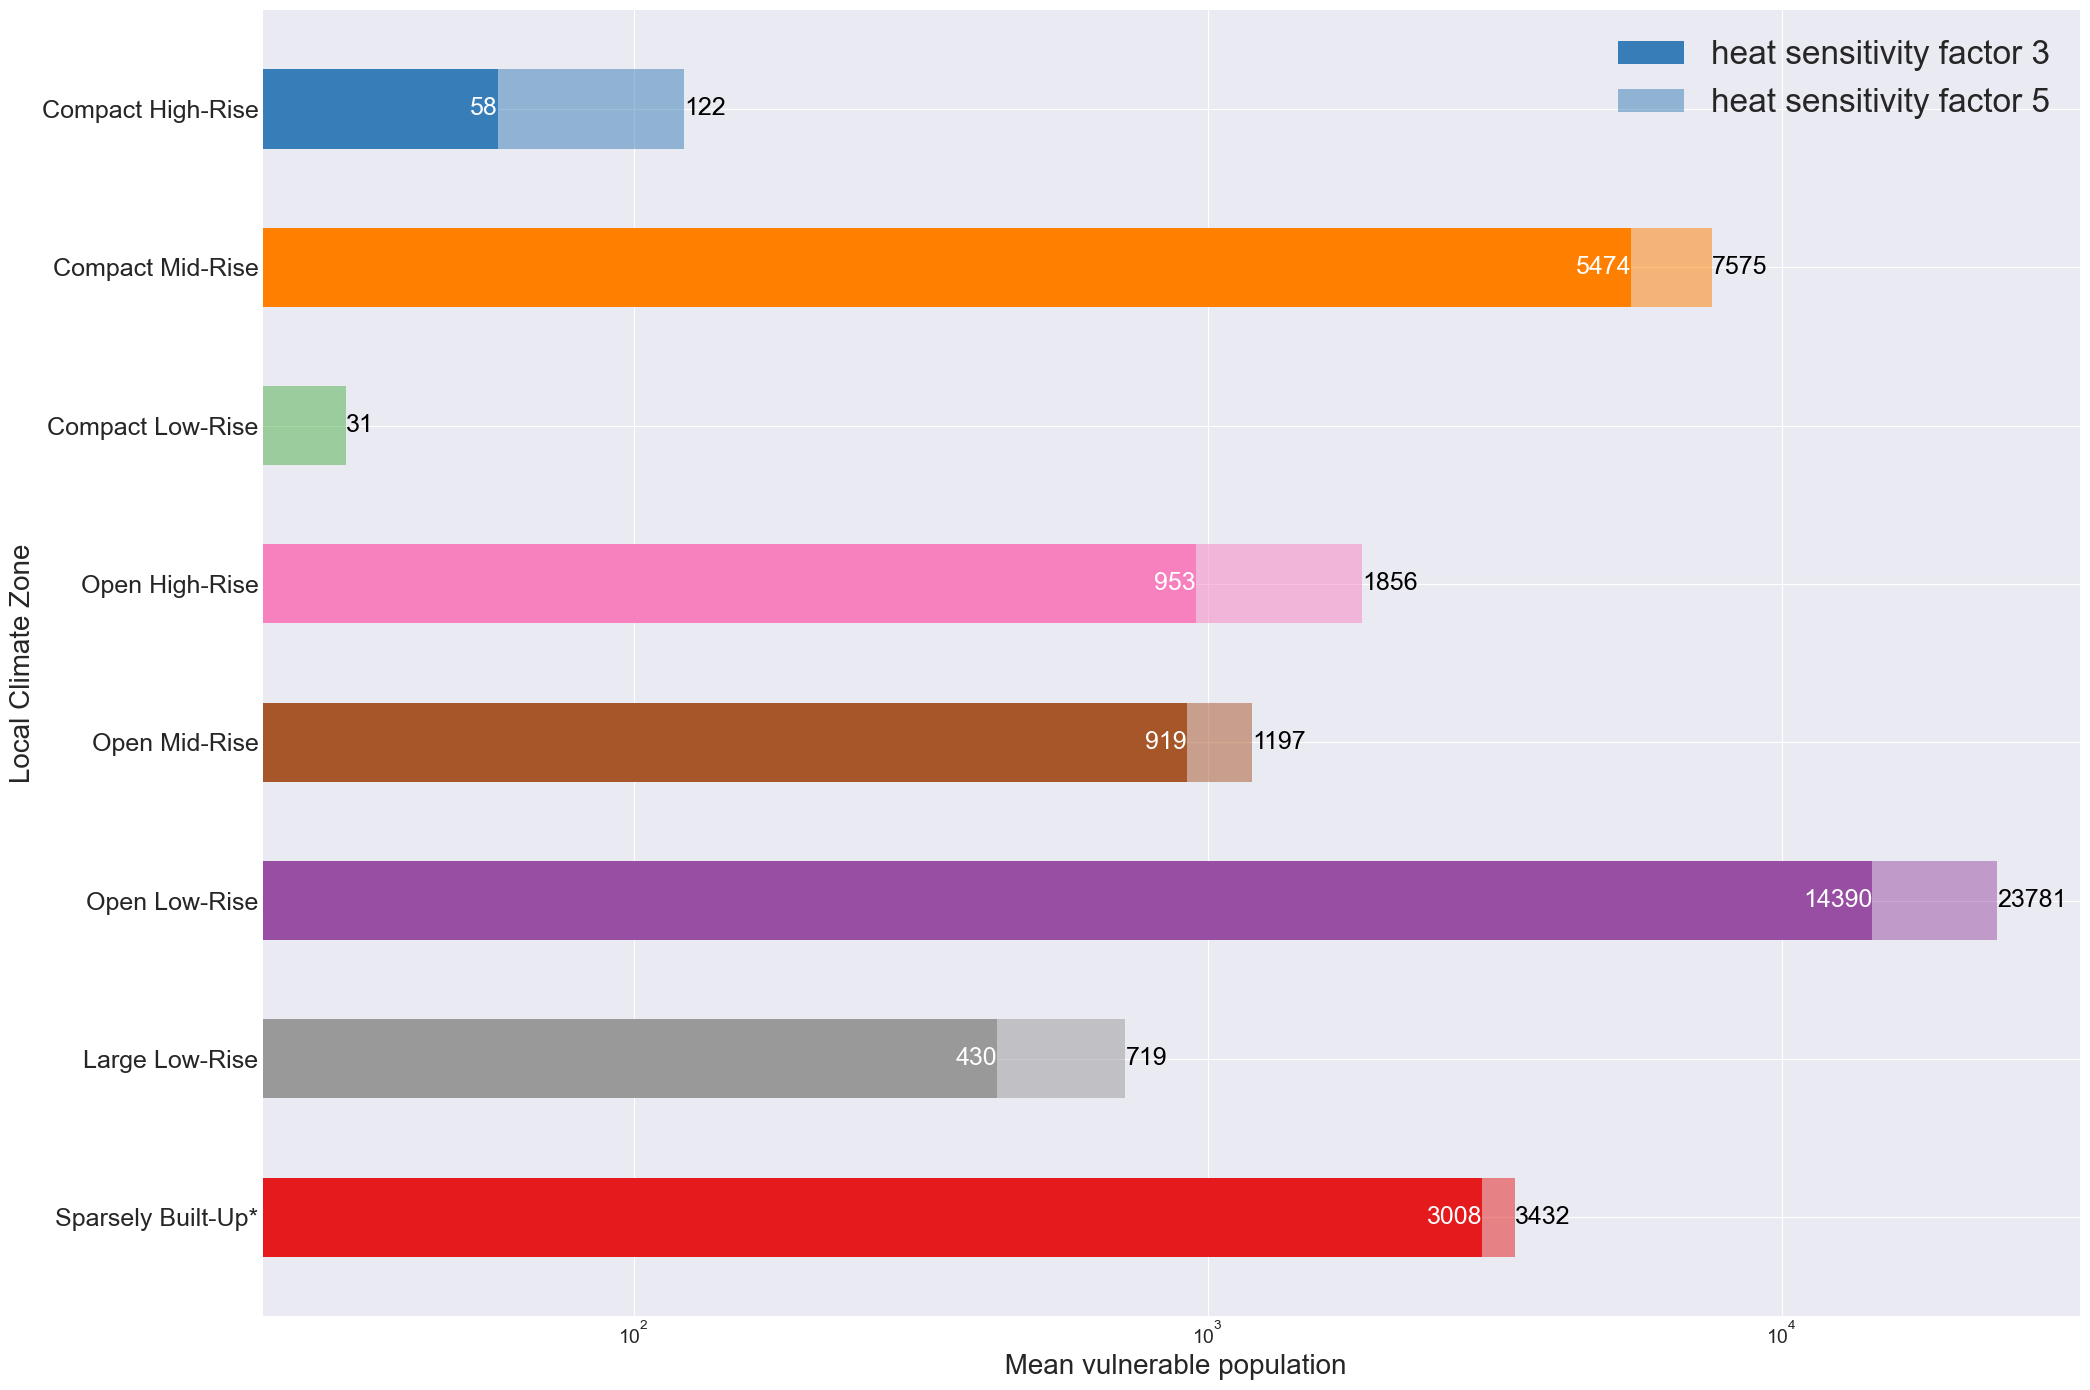

In [10]:
# Define column names as variables
para1 = 'lcz_class'
val = 'vulpop_perc'
abs_val = 'sum_vul_pop'

# Read data 
gdf = gpd.read_file(f'{Path.cwd()}/data/lcz_vularea_pop_density_diff_perc.json')

# Remove rows where 'value' is NaN
gdf = gdf.dropna(subset=[val])

# Remove rows where 'lcz_class' is > 10
gdf = gdf[gdf['lcz_class'] <= 10]

# Define a list of colors
colors = ['#377eb8', '#ff7f00', '#4daf4a',
          '#f781bf', '#a65628', '#984ea3',
          '#999999', '#e41a1c', '#dede00']

# Filter data for the specific conditions
conditions = [
    (gdf['shadow_factor'] == 5),
    (gdf['shadow_factor'] == 3)
]

labels = ['heat sensitivity factor 5', 'heat sensitivity factor 3']

# Create a figure for the absolute number of vulnerable people
fig, ax = plt.subplots(figsize=(21, 14))

# List of unique LCZ classes
lcz_classes = sorted(gdf[para1].unique())

# Create bar plot for each LCZ class
bar_width = 0.5
index = np.arange(len(lcz_classes))

# Plot for shadow_factor 3 (fully opaque)
condition_3 = conditions[1]
filtered_data_3 = gdf[condition_3]
grouped_data_3 = filtered_data_3.groupby(para1)[abs_val].mean().reindex(lcz_classes).fillna(0)
bars_3 = ax.barh(index, grouped_data_3, bar_width, label=labels[1], color=[colors[i] for i in range(len(lcz_classes))])

# Plot for shadow_factor 5 (semitransparent)
condition_5 = conditions[0]
filtered_data_5 = gdf[condition_5]
grouped_data_5 = filtered_data_5.groupby(para1)[abs_val].mean().reindex(lcz_classes).fillna(0)
bars_5 = ax.barh(index, grouped_data_5, bar_width, label=labels[0], color=[colors[i] for i in range(len(lcz_classes))], alpha=0.5)

# Add text annotations for both shadow_factor 3 and 5
for i, (rect3, rect5) in enumerate(zip(bars_3, bars_5)):
    width3 = grouped_data_3.iloc[i]
    width5 = grouped_data_5.iloc[i]
    
    if width3 > 0:
        ax.text(width3, rect3.get_y() + rect3.get_height() / 2, f'{int(width3)}', 
                ha='right', va='center', fontsize=18, color='white')
    
    if width5 > 0:
        ax.text(width5, rect5.get_y() + rect5.get_height() / 2, f'{int(width5)}', 
                ha='left', va='center', fontsize=18, color='black')

# Set title and labels
# ax.set_title('Mean vulnerable population per Locar Climate Zone at Hsf 3 and Hsf 5', fontsize=24)
ax.set_ylabel('Local Climate Zone', fontsize=20)
ax.set_xlabel(' Mean vulnerable population', fontsize=20)
ax.set_yticks(index)
ax.set_yticklabels(['Compact High-Rise', 'Compact Mid-Rise', 'Compact Low-Rise', 'Open High-Rise', 
                    'Open Mid-Rise', 'Open Low-Rise', 'Large Low-Rise', 'Sparsely Built-Up*'], ha='right', fontsize=18)
ax.legend(fontsize=24)

# Set x-axis to logarithmic scale
ax.set_xscale('log')
ax.tick_params(axis='x', labelsize=14)
ax.invert_yaxis()

# Adjust layout and spacing
plt.tight_layout()
plt.style.use('seaborn-v0_8-darkgrid')

# Save the plot as an image and display it
plt.savefig(f'{Path.cwd()}/img/LCZ-mean_vul_people_absolute_hf5_3.png', dpi=600)
plt.show()